# Trabalho No. 3

- Aluno: Guilherme Lisboa de Oliveira (GRR20170414)

```{admonition} Questões

Parte IV: Análise Espectral e Filtragem

Seção IV.11 Exercícios 9, 20 e 22
```

In [1]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import pandas as pd
import numpy as np

## Ex 9

A Figura IV.22 mostra o número de manchas solares suavizadas bi-ano (média móvel de 12 meses) de junho de 1749 a dezembro de 1978 com $n=459$ pontos que foram obtidos duas vezes por ano; os dados estão contidos em **sunspotz**. Com o Exemplo IV.13 como guia, execute uma análise de periodograma identificando os períodos predominantes e obtendo intervalos de confiança para os períodos identificados. Interprete suas descobertas.

![Figura IV.22](./imagens/Rplotsunspotz.png)

In [2]:
sunspotz = pd.read_csv('./dados/sunspotz.csv', index_col='index')
sunspotz.index = pd.DatetimeIndex(sunspotz.index)

Utilizamos a diferença entre observações consecutivas para remover tendência e assim também temos um número de observações pares:

In [3]:
x = np.diff(sunspotz.value)
num_diferenças = len(x) # 458
metade_num_diferenças = int(num_diferenças/2)

Plotando o periodograma (unilateral) temos um pico próximo de 0,05:

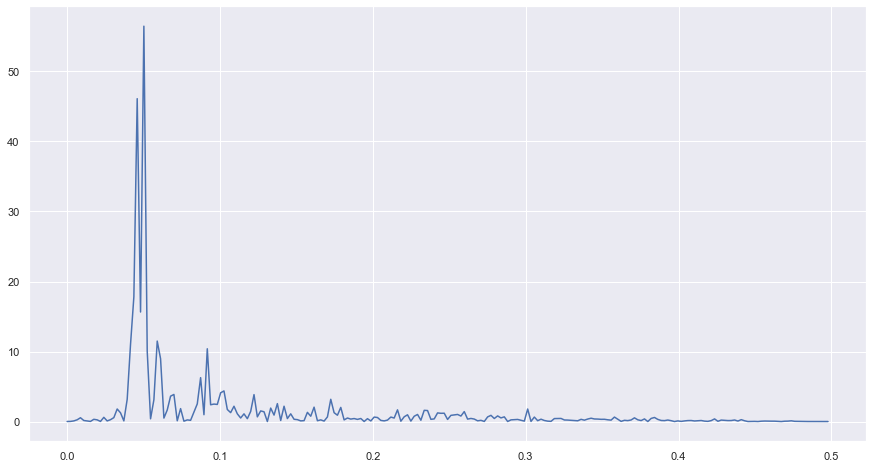

In [4]:
I = np.abs(np.fft.fft(x)/np.sqrt(num_diferenças)) ** 2
P = (4/num_diferenças)*I[slice(metade_num_diferenças)]
freq = np.linspace(0, 0.5, num=metade_num_diferenças, endpoint=False)

plt.figure(figsize=(15, 8))
plt.plot(freq, P);

Verificando a inspeção visual:

In [5]:
freq[np.argmax(P)]

0.05021834061135371

Portanto, a frequência encontrada corresponde a 1/0,05 = 20 observações. Como as observações são bi-anuais, 20 observações ocorrem no período de 10 anos. Assim, a periodicidade dominante é de 10 anos.

## Ex 20

Os dados no arquivo **climhyd** contém 454 meses de valores medidos para as variáveis climáticas: temperatura do ar (Temp), ponto de orvalho (DewPt), cobertura de nuvens (CldCvr), velocidade do vento (WndSpd), precipitação (Precip) e influxo (Inflow), no Lago Shasta; os dados são exibidos na Figura VII.3. Gostaríamos de examinar as possíveis relações entre os fatores climáticos e o influxo para o Lago Shasta.

(a) Ajuste um modelo $ARIMA(0,0,0)×(0,1,1)_{12}$ para (i) a precipitação transformada $P_t = \sqrt{Precip}$ e (ii) influxo transformado $I_t = ln(Inflow)$.

(b) Calcule as coerências quadradas entre todas as variáveis meteorológicas e o influxo transformado e argumente que o determinante mais forte da série de influxo é a precipitação (transformada). Dica: se $x$ contiver várias séries temporais, a maneira mais fácil de exibir todas as coerências quadradas é graficar as coerências suprimindo os intervalos de confiança.

(c) Ajuste um modelo de regressão defasada da forma $I_t = \beta_0+\sum_{j=0}^\infty \beta_j P_{t-j}+\omega_t$ usando limiarização e depois comentar a capacidade preditiva da precipitação para o influxo.

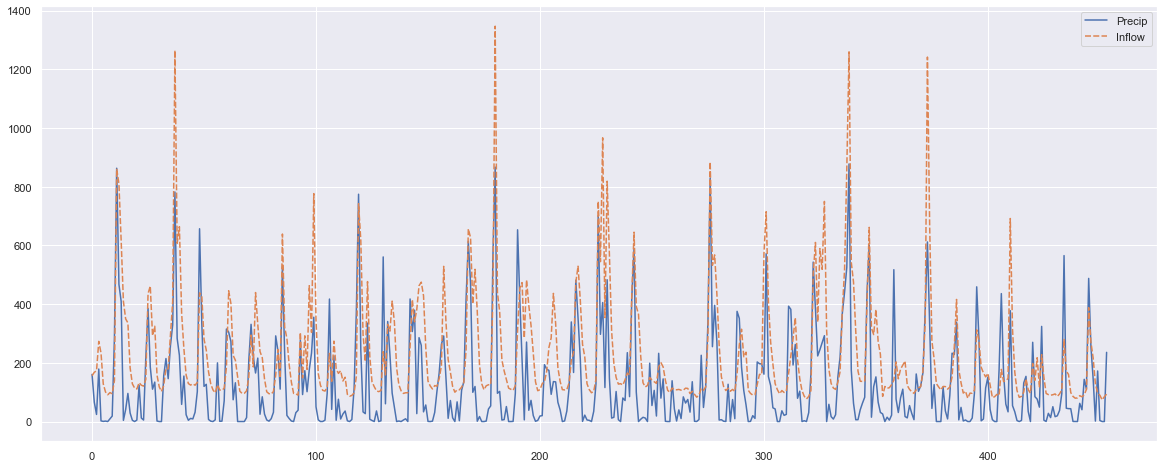

In [6]:
climhyd = pd.read_csv('./dados/climhyd.csv')

plt.figure(figsize=(20, 8))
sns.lineplot(data=climhyd[['Precip', 'Inflow']]);

(i) Ajuste modelo $P_t = \sqrt{Precip}$

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

ajuste_pt = SARIMAX(np.sqrt(climhyd.Precip), climhyd.drop('Precip', axis=1), order=(0,0,0), seasonal_order=(0, 1, 1, 12)).fit()
ajuste_pt.summary()

c:\DEV\Guilherme\estatisticaufpr\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                     Precip   No. Observations:                  454
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood               -1155.513
Date:                    Wed, 01 Feb 2023   AIC                           2325.027
Time:                            18:19:04   BIC                           2353.666
Sample:                                 0   HQIC                          2336.323
                                    - 454                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp          -0.7479      0.118     -6.362      0.000      -0.978      -0.517
DewPt          0.5838      0.117      5.005      0.000       0.355       0.812
CldCvr        16.3416      2.075      7.875      0.000      12.274      20.409
WndSpd         2.2853      1.038      2.201      0.028       0.250       4.321
Inflow         0.0131      0.001     11.734      0.000       0.011       0.015
ma.S.L12      -0.9179      0.031    -29.254      0.000      -0.979      -0.856
sigma2        10.3888      0.649     16.000      0.000       9.116      11.661
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                 3.80
Prob(Q):                              0.41   Prob(JB):                         0.15
Heteroskedasticity (H):               1.18   Skew:                             0.05
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

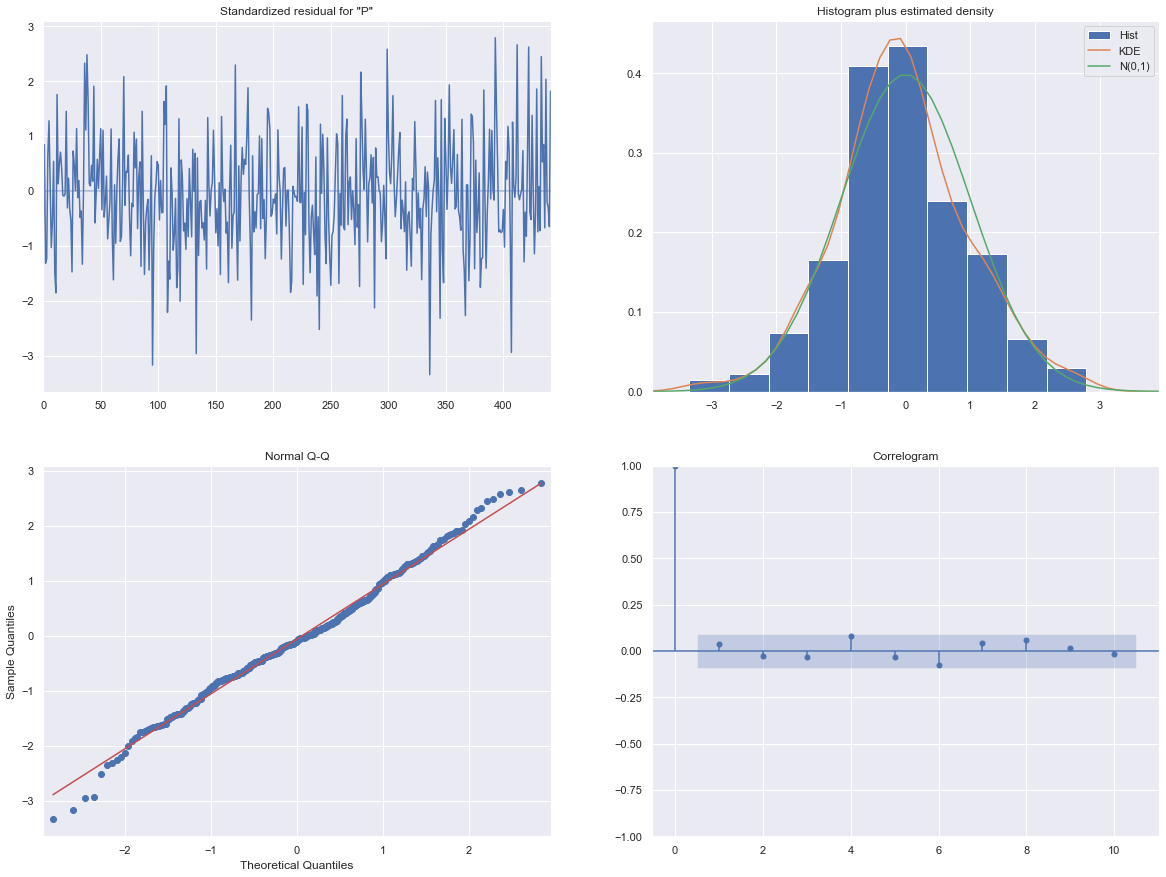

In [8]:
ajuste_pt.plot_diagnostics(figsize=(20,15));

O modelo mostra-se adequado, passando pelos testes de correlação, homocedasticidade e normalidade dos resíduos. Tanto as variáveis explicativas quanto os termos do modelo SARIMA proposto são significantes.

(ii) Ajuste modelo $I_t = ln(Inflow)$

In [9]:
ajuste_it = SARIMAX(np.log(climhyd.Inflow), climhyd.drop('Inflow', axis=1), order=(0,0,0), seasonal_order=(0, 1, 1, 12)).fit()
ajuste_it.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                     Inflow   No. Observations:                  454
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                -106.586
Date:                    Wed, 01 Feb 2023   AIC                            227.173
Time:                            18:19:09   BIC                            255.812
Sample:                                 0   HQIC                           238.469
                                    - 454                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp          -0.0220      0.010     -2.217      0.027      -0.041      -0.003
DewPt          0.0569      0.010      5.539      0.000       0.037       0.077
CldCvr        -0.1376      0.184     -0.750      0.453      -0.497       0.222
WndSpd         0.2510      0.103      2.426      0.015       0.048       0.454
Precip         0.0019      0.000     16.221      0.000       0.002       0.002
ma.S.L12      -0.7015      0.034    -20.675      0.000      -0.768      -0.635
sigma2         0.0929      0.005     17.981      0.000       0.083       0.103
===================================================================================
Ljung-Box (L1) (Q):                 118.35   Jarque-Bera (JB):                27.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

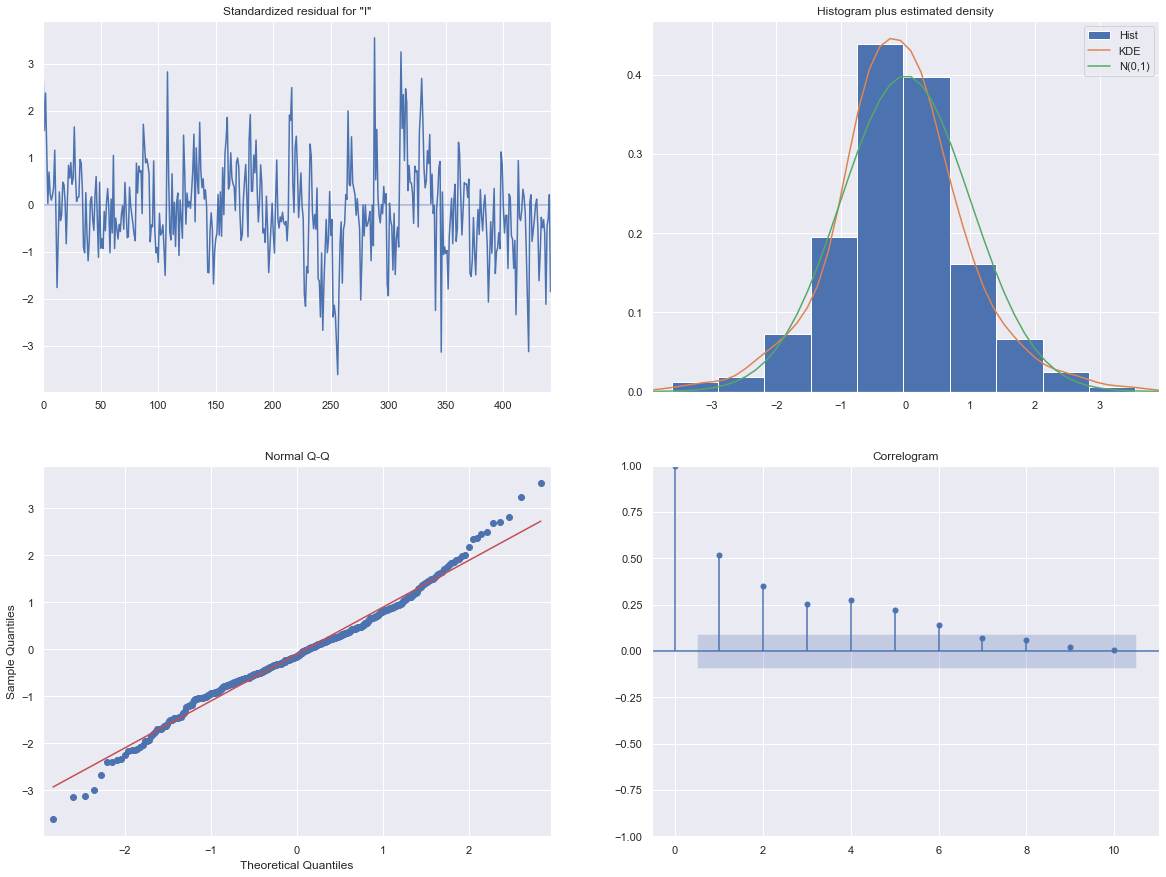

In [10]:
ajuste_it.plot_diagnostics(figsize=(20,15));

O modelo para o influxo apresenta principalmente um problema de correlação.

Correlação cruzada:

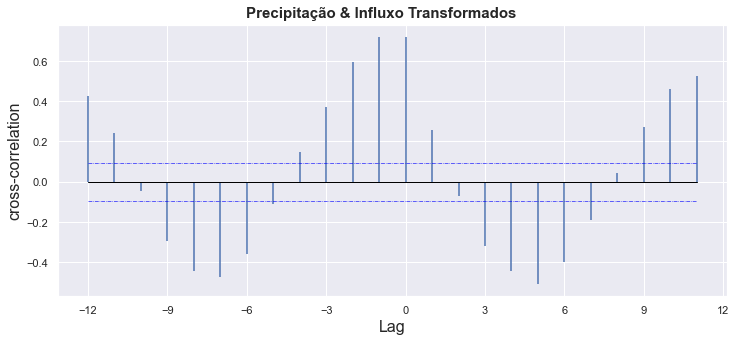

In [11]:
from utils.plot_ccf import plot_ccf

plot_ccf(np.sqrt(climhyd.Precip), np.log(climhyd.Inflow), 12, title="Precipitação & Influxo Transformados")

O gráfico de correlação cruzada mostra que há uma forte correlação entre Precipitação e Influxo, sendo que medidas de $t-1$ até $t-4$ ainda apresentam correlação positiva. Após esse período, passamos a ter uma correlação negativa, ou seja, o influxo do lago diminui se comparado há precipitação em $t$.

Parte da explicação poder ser atribuída há períodos chuvosos. (Fonte: https://weatherspark.com/y/666/Average-Weather-in-Shasta-Lake-California-United-States-Year-Round)

![Período Chuvoso](./imagens/shasta_lake_rainfall.png)

Vemos que os primeiros atrasasos ainda estão na temporada chuvosa (de Janeiro $t$ a Abril $t-4$). Já os atrasos $t-5$ até $t-10$ (Maio a Outubro) estão no período seco, ou seja, há um menor influxo no lago se comparado ao período $t$ de precipitação. Ao chegar no tempo $t-11$, voltam as chuvas e o influxo passa a ser correlacionado com a precipitação em $t$

## Ex 22

Analise os dados do preço do frango (**chicken**) usando um procedimento de estimação espectral paramétrica. Compare os resultados com os do Exercício 1, Seção IV.4.

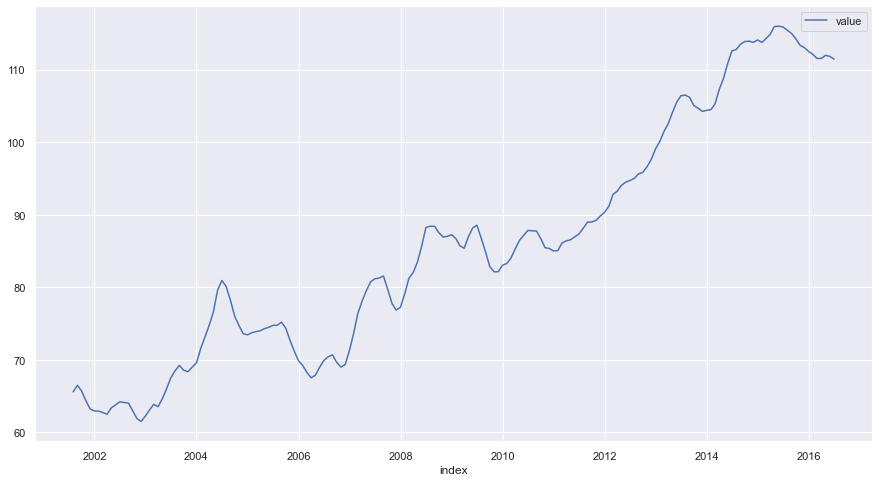

In [12]:
chicken = pd.read_csv('./dados/chicken.csv', index_col='index')
chicken.index = pd.DatetimeIndex(chicken.index)


plt.figure(figsize=(15, 8))
sns.lineplot(data=chicken);

O método escolhido implementa o algoritmo de Yule-Walker para estimar os parametros de um modelo AR(4):

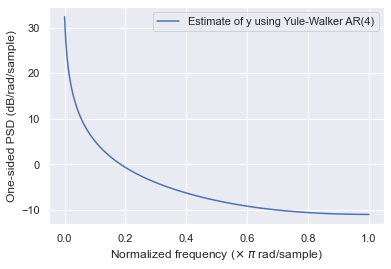

In [54]:
from spectrum import arma2psd, arburg, aryule
from pylab import plot, linspace, log10, pi, xlabel, ylabel, legend

AR, P, k = aryule(chicken.values, 4)
PSD = arma2psd(AR, NFFT=512)
PSD = PSD[len(PSD):len(PSD)//2:-1]
plot(linspace(0, 1, len(PSD)), 10*log10(abs(PSD)*2./(2.*pi)), label='Estimação de y usando Yule-Walker AR(4)')
xlabel(r'Frequência normalizada ($\times$ $\pi$ rad/sample)')
ylabel('One-sided PSD (dB/rad/sample)')
legend();